Recommendation System

In [1]:
#Initial setup
import pandas as pd
import numpy as np
import torch
from typing import List, Tuple, Sequence
SEED=20

In [2]:
#Reading the datasets
ratings_ds = pd.read_csv("/Users/rashmichakravarthy/Downloads/ml-latest-small/ratings.csv")
movies_ds = pd.read_csv("/Users/rashmichakravarthy/Downloads/ml-latest-small/movies.csv")

### Pre-processing Data

In [3]:
#Updating columns userId and movieId to readable strings 
ratings_ds['userId'] =  "usr" + ratings_ds['userId'].astype(str)
ratings_ds['movieId'] = "mov" + ratings_ds['movieId'].astype(str)
movies_ds['movieId'] = "mov" +  movies_ds['movieId'].astype(str)

In [4]:
ratings_ds.head()

,userId,movieId,rating,timestamp
0,usr1,mov1,4.0,964982703
1,usr1,mov3,4.0,964981247
2,usr1,mov6,4.0,964982224
3,usr1,mov47,5.0,964983815
4,usr1,mov50,5.0,964982931


In [5]:
movies_ds.head()

,movieId,title,genres
0,mov1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,mov2,Jumanji (1995),Adventure|Children|Fantasy
2,mov3,Grumpier Old Men (1995),Comedy|Romance
3,mov4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,mov5,Father of the Bride Part II (1995),Comedy


### User Preferences - Analysis

In [6]:
#Unique users in the dataset
ratings_ds['userId'].nunique()

610

In [7]:
#Average rating of each individual user
users_grouped= ratings_ds.groupby(['userId'])
users_avg_rating_ds=users_grouped['rating'].agg([np.average])
users_avg_rating_ds

,average
userId,
usr1,4.366379
usr10,3.278571
usr100,3.945946
usr101,3.557377
usr102,3.357143
...,...
usr95,4.062500
usr96,3.884615
usr97,4.194444


For simplicity let us consider a user(say usr100) and analyse the rating proviided by that user. 

In [8]:
#pd. set_option('display.max_rows', None)
User100_ds = pd.merge(ratings_ds[ratings_ds["userId"]=='usr100'], movies_ds, on=["movieId"]).sort_values(by="rating", ascending=False)
User100_ds

,userId,movieId,rating,timestamp,title,genres
86,usr100,mov1958,5.0,1100186258,Terms of Endearment (1983),Comedy|Drama
101,usr100,mov2423,5.0,1100186118,Christmas Vacation (National Lampoon's Christm...,Comedy
137,usr100,mov5620,5.0,1100186982,Sweet Home Alabama (2002),Comedy|Romance
55,usr100,mov1101,5.0,1100184137,Top Gun (1986),Action|Romance
125,usr100,mov4041,5.0,1100184235,"Officer and a Gentleman, An (1982)",Drama|Romance
...,...,...,...,...,...,...
105,usr100,mov2513,2.0,1100186111,Pet Sematary (1989),Horror
110,usr100,mov2710,2.0,1100277691,"Blair Witch Project, The (1999)",Drama|Horror|Thriller
67,usr100,mov1288,2.0,1100185857,This Is Spinal Tap (1984),Comedy
4,usr100,mov19,1.0,1100183757,Ace Ventura: When Nature Calls (1995),Comedy


In [9]:
#Counting the frequency of each genere that user with userId=usr100 has prefered to watch can be 
from itertools import chain
from collections import Counter
pd.Series(
    Counter(chain.from_iterable(x.split('|') for x in User100_ds.genres)))

Comedy       85
Drama        74
Romance      79
Action       26
Crime        12
Thriller     19
Children      6
Fantasy      10
Musical      12
Adventure    17
Western       5
War           6
Sci-Fi        7
IMAX          1
Mystery       5
Animation     2
Horror        5
dtype: int64

From the above Information we can infer that usr100 is more likely to watch movies of genre Comedy, and has also given more rating to such movies.

Now let us consider two more users ( say usr10 and usr95) and analysing them with specific movie categories.

In [10]:
#Frequency of each individual genre
pd.Series(
    Counter(chain.from_iterable(x.split('|') for x in movies_ds.genres)))

Adventure             1263
Animation              611
Children               664
Comedy                3756
Fantasy                779
Romance               1596
Drama                 4361
Action                1828
Crime                 1199
Thriller              1894
Horror                 978
Mystery                573
Sci-Fi                 980
War                    382
Musical                334
Documentary            440
IMAX                   158
Western                167
Film-Noir               87
(no genres listed)      34
dtype: int64

In [11]:
#Movies with "Drama" (highest frequency) genre that usr10 has rated positively (>=4)
usr10 = pd.merge(
    ratings_ds[(ratings_ds["userId"]=='usr10') & (ratings_ds["rating"] >= 4.0)],
    movies_ds[movies_ds["genres"].str.contains('Drama')],
    on = ["movieId"]).sort_values(by="rating", ascending = False)

#Movies with "Drama" (highest frequency) genre that usr100 has rated positively (>=4)
usr95 = pd.merge(
    ratings_ds[(ratings_ds["userId"]=='usr95') & (ratings_ds["rating"] >= 4.0)],
    movies_ds[movies_ds["genres"].str.contains('Drama')],
    on = ["movieId"]).sort_values(by="rating", ascending = False)

print(len(usr10))
print(len(usr95))

#Percentage of all positive ratings (>=4) of usr10 for movies belonging to the "Drama" (highest frequency) genre
u10_ALL_ratings = pd.merge( ratings_ds[ratings_ds["userId"]=='usr10'], movies_ds, on=["movieId"])['rating'].count()
print((len(usr10)/u10_ALL_ratings))

26
62
0.18571428571428572


### Popularity-based Recomendation (considering movie ratings)

In [12]:
group_Count_Series = ratings_ds[["movieId", "rating"]].groupby(["movieId"]).count()
group_Count_Series

,rating
movieId,
mov1,215
mov10,132
mov100,14
mov100044,1
mov100068,1
...,...
mov99853,1
mov999,12
mov99910,2


[]

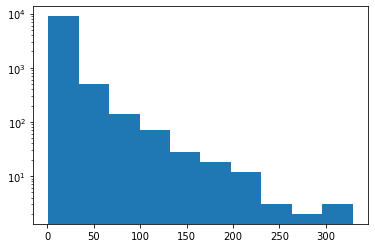

In [13]:
#Histogram plot depiction of distribution of movie ratings from the group_Count_Series dataset
import matplotlib.pyplot as ppl
ppl.hist(group_Count_Series['rating'], log = True)
ppl.plot()

In [14]:
#Names of all of the movies that have the highest average ratings 
#Average rating for each individual movie is deduced and denoted by the column 'average rating'
avg_rating_indv_movie = ratings_ds.groupby(['movieId'])['rating'].agg([np.average]).reset_index().rename(columns={"average" : "average rating"})

#Count of ratings given to each of those movies is calculated and denoted by the column to 'number of ratings'
rating_count_indv_movie = ratings_ds.groupby(['movieId'])['rating'].count().reset_index().rename(columns={"rating" : "number of ratings"})

#Merging the dataset movies_ds with each movie (with their average rating)
merge_movie_avgrating = pd.merge(
    movies_ds,
    avg_rating_indv_movie,
    on=["movieId"])

#Merging the dataset movies_ds with each movie (with their average rating count)
merge_movie_avgratingcount = pd.merge(
    merge_movie_avgrating,
    rating_count_indv_movie,
    on=["movieId"])

#Movies with maximum average rating
max_movie_avgrating = merge_movie_avgratingcount[merge_movie_avgratingcount['average rating'] == 5.0]
max_movie_avgrating

,movieId,title,genres,average rating,number of ratings
48,mov53,Lamerica (1994),Adventure|Drama,5.0,2
87,mov99,Heidi Fleiss: Hollywood Madam (1995),Documentary,5.0,2
121,mov148,"Awfully Big Adventure, An (1995)",Drama,5.0,1
405,mov467,Live Nude Girls (1995),Comedy,5.0,1
432,mov495,In the Realm of the Senses (Ai no corrida) (1976),Drama,5.0,1
...,...,...,...,...,...
9593,mov176601,Black Mirror,(no genres listed),5.0,1
9615,mov179133,Loving Vincent (2017),Animation|Crime|Drama,5.0,1
9616,mov179135,Blue Planet II (2017),Documentary,5.0,1
9670,mov184245,De platte jungle (1978),Documentary,5.0,1


Considering all of the positive ratings (>=4). The most popular pairs of movies that the users have watched:

In [15]:
positive_rating = ratings_ds[ratings_ds["rating"]>=4]

#All pairs of movies watched by a given user.
movie_pairs = pd.merge(positive_rating, positive_rating, on=["userId"])

#We only consider A->B, not B->A. Hence, usinng the timestamps to limit the selected pairs
sequence_selected = movie_pairs[movie_pairs["timestamp_x"] < movie_pairs["timestamp_y"]] 

#Frequency of each pair of the movies
movie_paircount = sequence_selected[["movieId_x", "movieId_y", "userId"]].groupby(["movieId_x", "movieId_y"]).count()

#Sorting the most popular movie pairs
popular_moviepairs = movie_paircount.reset_index().rename(columns={"userId" : "count"}).sort_values(['count'], ascending=False)

#Top most frequent movie pairs
popular_moviepairs.head()

,movieId_x,movieId_y,count
1574483,mov318,mov356,104
1416644,mov296,mov593,92
1416033,mov296,mov47,91
1187221,mov260,mov1196,91
1575263,mov318,mov527,90


Positively rated popular movie pair titles :

In [16]:
#A temporary dataset to store data pertaining movieId_x
x_temp = popular_moviepairs.merge( right = movies_ds[['movieId','title']], left_on= 'movieId_x', right_on='movieId')

#A temporary dataset to store data pertaining movieId_y
y_temp = x_temp.merge( right = movies_ds[['movieId','title']], left_on= 'movieId_y', right_on='movieId')

#Merging the two datasets ensuring removal of the duplicated rows
xy_temp = y_temp.loc[:,~y_temp.columns.duplicated()]

#get the number of counts in movie pairs and display it
popular_moviepairs_titles = xy_temp.sort_values(['count'], ascending=False)

popular_moviepairs_titles


,movieId_x,movieId_y,count,title_x,title_y
0,mov318,mov356,104,"Shawshank Redemption, The (1994)",Forrest Gump (1994)
5993,mov296,mov593,92,Pulp Fiction (1994),"Silence of the Lambs, The (1991)"
22257,mov260,mov1196,91,Star Wars: Episode IV - A New Hope (1977),Star Wars: Episode V - The Empire Strikes Back...
17759,mov296,mov47,91,Pulp Fiction (1994),Seven (a.k.a. Se7en) (1995)
2122,mov318,mov527,90,"Shawshank Redemption, The (1994)",Schindler's List (1993)
...,...,...,...,...,...
1515989,mov2077,mov4865,1,"Journey of Natty Gann, The (1985)",From Hell (2001)
1515990,mov213,mov4865,1,Burnt by the Sun (Utomlyonnye solntsem) (1994),From Hell (2001)
1515991,mov6985,mov4865,1,"Passion of Joan of Arc, The (Passion de Jeanne...",From Hell (2001)
1515992,mov1785,mov4865,1,King of New York (1990),From Hell (2001)


With the above information it can be inferred that the movie pairs with the highest rating, and likely to be most popular are The Shawshank Redemption and Forrest Grump.

# User-based Collaborative Filtering
A matrix of ratings is generated with the ratings_ds dataset. In which, the unrated items are denoted with 0 (implying they have no impact on the calculated Cosine value).

In [17]:
rating_ds_matrix = ratings_ds.pivot_table(index='userId', columns='movieId', values='rating').fillna(0)
rating_ds_matrix

movieId,mov1,mov10,mov100,mov100044,mov100068,mov100083,mov100106,mov100159,mov100163,mov100194,...,mov99750,mov99764,mov998,mov99813,mov99846,mov99853,mov999,mov99910,mov99917,mov99992
userId,,,,,,,,,,,,,,,,,,,,,
usr1,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
usr10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
usr100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
usr101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
usr102,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
usr95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
usr96,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
usr97,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


User-based Collaborative Filtering extensively relies upon Cosine similarity. Thus, implementating the Cosine similarity:

In [18]:
def cosine_sim(x, y):
  from numpy.linalg import norm
  from numpy import dot
  return dot(x, y)/(norm(x)*norm(y))

#Let us consider any user say usr98 and deduce the cosine similarity between the user and itself
print('Cosine Similarity between usr98 to itself is:')
print(cosine_sim(rating_ds_matrix.loc['usr97'].values, rating_ds_matrix.loc['usr97'].values))

#Let us consider any users say usr98, usr1 and calculate the cosine similarity between the two users 
print('Cosine similarity between usr1 and usr98 is:')
print(cosine_sim(rating_ds_matrix.loc['usr1'].values, rating_ds_matrix.loc['usr98'].values))

Cosine Similarity between usr98 to itself is:
1.0
Cosine similarity between usr1 and usr98 is:
0.06218737985717063


### Getting the most similar users

User-based CF is based on nearest-neighbours and their similarity to each other. 
Identify the userIds of the k most similar users to that of the specified userId, and their corresponding cosine similarities:

In [19]:
from scipy.stats import rankdata
import heapq

def get_most_similar_users(userId : str, k : int = 10) -> Tuple[Sequence[str], Sequence[float]]:
  # a list/numpy array of k userIds of top-k users
  topk_userids = [] 
  # a list/numpy array of k cosine similarity values
  topk_cosinesim = []  
  #Using for loop to get cosine similarity of each user
  result = {}
  for i in rating_ds_matrix.index:
    result[i] = cosine_sim(rating_ds_matrix.loc[i].values, rating_ds_matrix.loc[userId].values)
  #sort the resultant array
  result = sorted(result.items(), key=lambda item: item[1], reverse=True)

  for i in range(k):
    topk_userids.append(result[i+1][0])
    topk_cosinesim.append(result[i+1][1])
  
  return (topk_userids, topk_cosinesim)

print(get_most_similar_users(userId='usr1', k=1))

(['usr266'], [0.3574077096032742])


### Predicting ratings via user-based CF

This function is aimed at predicting the rating of a given userId (user) for a given movieId (item)

In [20]:
def um_predict_rating(userId : str, movieId : str) -> float:
 
  n_userId, n_similar = get_most_similar_users(userId, 10)
  
  n_ratings = []
  
  for i in n_userId:
    rating = rating_ds_matrix.loc[i][movieId]
    n_ratings.append(rating)

  print(n_ratings, "\n\n")
  predicted = 0 

  predicted = np.divide(np.sum(np.multiply(np.array(n_similar), np.array(n_ratings))), np.sum(np.array(n_similar))) # predicted rating value
  
  return predicted

print("Predicted rating:", um_predict_rating(userId='usr1', movieId='mov1'))

print("Actual rating:", rating_ds_matrix.loc['usr1']['mov1'])

[2.0, 0.0, 0.0, 5.0, 4.0, 4.0, 0.0, 4.5, 0.0, 4.0] 


Predicted rating: 2.3363751766665386
Actual rating: 4.0


### Predicting ratings via user-based CF ( with Mean-center normalisation)

In [21]:
def meancenternorm_rating(userId : str) -> float:
  total = np.count_nonzero(rating_ds_matrix.loc[userId])
  meancenternorm_rating = (np.sum(rating_ds_matrix.loc[userId]))/total # mean-centering value
  return meancenternorm_rating

print("Mean rating of user usr5:", meancenternorm_rating('usr5') )

def predict_rating_mcn(userId : str, movieId : str) -> float:

  n_userId, n_similar = get_most_similar_users(userId, 10)
  
  n_ratings = []
  avg_ratings = []

  for i in n_userId:
    rating = rating_ds_matrix.loc[i][movieId]
    n_ratings.append(rating)

    avg_ratings.append(meancenternorm_rating(i))


  avg_target_rating = meancenternorm_rating(userId)
  predicted = 0 # predicted rating value with mean-centering

  predicted = avg_target_rating + np.divide(np.sum(np.multiply(np.array(n_similar), np.subtract(np.array(n_ratings), np.array(avg_ratings)))), np.sum(np.array(n_similar)))

  return predicted

print("Predicted rating:", predict_rating_mcn('usr1', 'mov1'))
print("Actual rating:", rating_ds_matrix.loc['usr1']['mov1'])

Mean rating of user usr5: 3.6363636363636362
Predicted rating: 3.127985053034213
Actual rating: 4.0


### Explicit Matrix Factorisation using Spotlight

In [22]:
from collections import defaultdict
from itertools import count

#create userId -> uid mapping dictionary. the next assigned value is the current size.
uid_map = defaultdict(count().__next__)
#ditto for movieId -> iid
iid_map = defaultdict(count().__next__)

#uids is an array of integers corresponding to the userId for every row in ratings_df
#uid_map does the assignment of new uid values, or reusing the uid value assigned for
#each userId
uids = np.array([uid_map[uid] for uid in ratings_ds["userId"].values ], dtype=np.int32)
#similar for iids
iids = np.array([iid_map[iid] for iid in ratings_ds["movieId"].values ], dtype=np.int32)

#freeze uid_map and iid_map so no more mappings are created
uid_map.default_factory = None
iid_map.default_factory = None

#reverse them, so we can go from iid (int) to itemId (str)
uid_rev_map = {v: k for k, v in uid_map.items()}
iid_rev_map = {v: k for k, v in iid_map.items()}
num_items = len(iid_map)
num_users = len(uid_map)

print("%d users %d item" % (num_users, num_items))

ratings = ratings_ds["rating"].values.astype(np.float32)
timestamps = ratings_ds["timestamp"].values.astype(np.int32)

print("userId %s got uid %d" % ("usr556", uid_map["usr556"]))
print("movieId %s got iid %d" % ("mov54001", iid_map["mov54001"]))

610 users 9724 item
userId usr556 got uid 555
movieId mov54001 got iid 2518


#### Now let's build a Spotlight Interactions object. This contains everything that Spotlight needs to train a model. We can split it up randomly into train and test subsets
NB: we use a SEED (20) to make our results reproducible.

In [23]:
from spotlight.interactions import Interactions
from spotlight.cross_validation import random_train_test_split

dataset = Interactions(user_ids=uids,
                                  item_ids=iids,
                                  ratings=ratings,
                                  timestamps=timestamps)

#lets initialise the seed, so that its repeatable and reproducible 
train, test = random_train_test_split(dataset, random_state=np.random.RandomState(SEED))

In [24]:
print(train)
print(test)

<Interactions dataset (610 users x 9724 items x 80668 interactions)>
<Interactions dataset (610 users x 9724 items x 20168 interactions)>


Learning the model with a matrix factorisation for explicit data

In [25]:
from spotlight.factorization.explicit import ExplicitFactorizationModel
import time  

efmodel = ExplicitFactorizationModel(n_iter=10,
                                    embedding_dim=32, #this is Spotlight default
                                    use_cuda=False,
                                    random_state=np.random.RandomState(SEED) # ensure results are repeatable
)
current = time.time()

efmodel.fit(train, verbose=True)

end = time.time()
timdiff = end - current
print("Training the data took %d seconds "% (timdiff))

Epoch 0: loss 4.308109071247185
Epoch 1: loss 0.8099100857595855
Epoch 2: loss 0.5096786405089535
Epoch 3: loss 0.363663408763801
Epoch 4: loss 0.29197124089998533
Epoch 5: loss 0.25697738153836397
Epoch 6: loss 0.2364348184930373
Epoch 7: loss 0.22271784644904016
Epoch 8: loss 0.21399803907622264
Epoch 9: loss 0.20728892842425575
Training the data took 5 seconds 


Let us look at the recommentations for a specific use with userId usr500. - How well is the model doing?

In [26]:
userId = "usr500"

# convert the string to the internal integer
uid = uid_map.get(userId)
print("Test item_id for userId %s (uid %d) is " % (userId, uid))

# pick one rating that the user made
testItemId = test.item_ids[test.user_ids == uid][0] 
print("Test movieId is %s iid %d " % (iid_rev_map.get(testItemId), testItemId ) )


#here 0 is a dummy item, which Spotlight needs for some reason...
#we discard its prediction using [1]
predicted = efmodel.predict( np.array([uid]), item_ids=np.array([0, testItemId]) )[1]

#what was the actual score of the user for that movie?
#we can get the appropriate row from the ratings dataframe, then extract that value
actual = ratings_ds[(ratings_ds.movieId==iid_rev_map.get(testItemId)) & (ratings_ds.userId==userId)]["rating"].values[0]


def getMovieTitle(iid):
  return movies_ds[movies_ds['movieId'] == iid_rev_map.get(iid)]["title"].values[0]

print("Predicted rating for '%s' was %f, actual rating %0.1f, error was %f" % (getMovieTitle(testItemId), predicted, actual, abs(predicted-actual) )) 



Test item_id for userId usr500 (uid 499) is 
Test movieId is mov1175 iid 2074 
Predicted rating for 'Delicatessen (1991)' was 4.002381, actual rating 5.0, error was 0.997619


It is interesting to note, that while the predicted rating for the movie 'Delicatessen (1991)' was ~4 the user has given an actual rating of 5.0

We can also ask for all of the recommendations for the given user (usr500):

In [27]:
allpreds = efmodel.predict( np.array([uid]) )

print(allpreds)
print(allpreds.size)

#we can recover the original rating for our test item 
print(allpreds[testItemId])

# lets just check we got the correct prediction
print(allpreds[testItemId] - actual < 0.1)

[4.2345123  2.300968   2.660574   ... 0.89837855 2.2653556  0.785812  ]
9724
4.002381
True


### Evaluating performance

Finally, let us look at how good our model is at predicting rating.

In [28]:
from spotlight.evaluation import rmse_score

train_rmse = rmse_score(efmodel, train)
test_rmse = rmse_score(efmodel, test)

print('Train RMSE {:.3f}, Test RMSE {:.3f}'.format(train_rmse, test_rmse))

Train RMSE 0.421, Test RMSE 0.454


### Implicit Recommendation

We use a music dataset from Last.fm (a Spotify-like) music streaming service 

In [29]:
#Reading dataset
music_ds = pd.read_csv("/Users/rashmichakravarthy/Downloads/lastfm-dataset-1K/userid-timestamp-artid-artname-traid-traname.tsv", names=['user', 'timestamp', 'artistid', 'artist', 'trackid', 'trackname'], header=None, sep='\t')

### Data - Preprocessing

In [30]:
#Dropping the tracks that dont have artists or track name
music_ds = music_ds[music_ds.artist.notnull()]
music_ds = music_ds[music_ds.trackname.notnull()]

#As the dataset has about 19M interactions, learning from a small sample will be faster and efficient 
music_ds = music_ds.sample(n=200000, random_state=np.random.RandomState(SEED))

In [34]:
music_ds.head()

,user,timestamp,artistid,artist,trackid,trackname
11087179,user_000593,2007-05-14T18:49:03Z,ad996aef-cc1c-42ac-af5c-619c370f4b8a,"Emerson, Lake & Palmer",NaN,Three Fates (Clotho/Lachesis/Atropos)
1911790,user_000093,2008-08-18T22:04:59Z,8c538f11-c141-4588-8ecb-931083524186,Bloc Party,315a301e-e764-4adf-91c6-e90a22320106,Positive Tension
11099786,user_000594,2008-04-06T10:57:45Z,65f4f0c5-ef9e-490c-aee3-909e7ae6b2ab,Metallica,683c89fe-2be8-4ed2-8e58-68b2343cb8d5,Through The Never
12076983,user_000651,2008-05-10T07:14:45Z,3ca09fae-fdee-4771-bab9-244708515a98,Omarion,NaN,Ice Box [Orangefuzzz Weather Advisory Radio Mix]
2680461,user_000137,2009-03-11T23:17:22Z,af84ee9f-534a-4f7f-844b-188ba1c47e87,Los Rodríguez,76b83f07-3763-4c17-8d24-28040d85354a,Dulce Condena


### Implicit recommendation approach

In [32]:
from collections import defaultdict
from itertools import count

#Building item ids based on artists & trackname attributes
Last_FMiid_map = defaultdict(count().__next__)
Last_FMiids = np.array([Last_FMiid_map[artist+"/"+trackname] for artist,trackname in music_ds[["artist","trackname"]].values ], dtype=np.int32)
Last_FMuid_map = defaultdict(count().__next__)
Last_FMuids = np.array([Last_FMuid_map[uid] for uid in music_ds["user"].values ], dtype=np.int32)

#freezing uid_map and iid_map so that there is no excessive mapping 
Last_FMuid_map.default_factory = None
Last_FMiid_map.default_factory = None
Last_FMuid_rev_map = {v: k for k, v in Last_FMuid_map.items()}
Last_FMiid_rev_map = {v: k for k, v in Last_FMiid_map.items()}

from spotlight.interactions import Interactions
from spotlight.cross_validation import random_train_test_split

#Setting up num_users and num_items and assigning it to a new dataset
refinedLFM_impds = Interactions(user_ids=Last_FMuids, item_ids=Last_FMiids, num_users=len(Last_FMuid_map), num_items=len(Last_FMiid_map))

print(refinedLFM_impds)

<Interactions dataset (973 users x 125076 items x 200000 interactions)>


In [33]:
from spotlight.cross_validation import random_train_test_split

imp_train, imp_test = random_train_test_split(refinedLFM_impds, random_state=np.random.RandomState(SEED))
print(imp_train)
print(imp_test)

<Interactions dataset (973 users x 125076 items x 160000 interactions)>
<Interactions dataset (973 users x 125076 items x 40000 interactions)>


Implementing Spotlight's implicit Matrix Factorisation on this dataset uses a pointwise loss, which predicts whether the user will like the item (track) or not. 

In [35]:
from spotlight.factorization.implicit import ImplicitFactorizationModel
import time  

imp_model = ImplicitFactorizationModel(n_iter=5, 
                                    embedding_dim=32, #this is Spotlight default
                                    use_cuda=False,
                                    random_state=np.random.RandomState(SEED) # ensure results are repeatable
)
current = time.time()

imp_model.fit(imp_train, verbose=True)
end = time.time()
time_diff = end - current
print("Training the data took %d seconds" % (time_diff))

Epoch 0: loss 0.966311330986023
Epoch 1: loss 0.49532541584968565
Epoch 2: loss 0.19036925075054167
Epoch 3: loss 0.11518937364816666
Epoch 4: loss 0.08347158861756325
Training the data took 42 seconds


### Track Analysis

Identifying the artist name & track of the top K (e.g. K=4) items based on their score for a given user index (i.e. 0.. 964)
The top scored 10 tracks recommended for user (say uid 3)?

In [36]:
def tracksForUser(user):
  
  #Score list of all items of given user
  score_list = imp_model.predict(4)
  score_list = score_list*-1

  #Ranking these scores
  rank_list = rankdata(score_list)
  #Finding the Top k scores
  answer = np.argwhere(rank_list <= 10)

  #Getting the artist and track names
  for i in answer:
    print(Last_FMiid_rev_map[i.item(0)])

tracks = tracksForUser(4)

Radiohead/Fake Plastic Trees
Amy Winehouse/Back To Black
The Killers/Bones
Him/The Funeral Of Hearts
Incubus/Drive
Kings Of Leon/Use Somebody
Mgmt/Kids
Nelly Furtado/Say It Right
Evanescence/Sweet Sacrifice
Red Hot Chili Peppers/The Zephyr Song


### Artist Analysis

Examining artists actually listened to by uid 3, and comparing the predictions of the recommender system. 
(It is useful to determine how many times each artist was listened to)

In [37]:
artist_groups = music_ds[music_ds['user'] == Last_FMuid_rev_map.get(3)].groupby(by=['artist'])['user'].count()
frequency = artist_groups.sort_values(ascending=False)
frequency.head(10)

artist
Alex Gaudino      7
Fragma            6
Atb               6
Samantha James    6
Kate Ryan         5
Ian Van Dahl      5
Nelly Furtado     5
Reina             4
Thalía            4
Paul Van Dyk      4
Name: user, dtype: int64

The information that can be obtained is thar user with uid 3, has listened to ALex Gaudino the most number of times

### Evaluation - Implicit Recommender

We can examine the MRR of the implicit model we have learned. We pass it the test set (which contains knowledge of what the user *actually* clicked), as our ground truth. 

In [38]:
from spotlight.evaluation import mrr_score

print(mrr_score(imp_model, imp_test).mean())
print(mrr_score(imp_model, imp_test,  train=imp_train).mean())


0.03739702115858334
0.008104536778740273
